# Tree leaf recognition
## Explication du code
GROUPE 3TL1:
LOUIS BAUCHAU
LOGAN MONTALTO
DEVASHISH BASNET
BRICE KOUETCHEU

### 1. Librairies, Variables Globals, Créations de dossiers

#### 1.1 Librairies

In [ ]:
import os
import numpy as np
import caer
import tensorflow as tf
import shutil
import makegraph
import makepreproccesing
from prettytable import PrettyTable
import pandas as pd
from keras.preprocessing import image
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sqrt, floor
from matplotlib import colors

#### 1.2 Variable Globals

In [ ]:
char_path_train = './Datasets/train'  # chemin vers le dossier train
char_path_validation = './Datasets/validation'  # chemin vers le dossier validation
char_path_test = './Datasets/test'  # chemin vers le dossier test
model_version = 25  # la version du modèle
modelse = 'model_' + str(model_version)  # nom complet du model

IMG_SIZE = (64, 64)  # resize des images
channels = 1
BATCH_SIZE = 32
EPOCHS = 50
dict = {}
leaf = []  # tableau comportant les feuilles de train et validation
sample_count = []  # tableau comportant le nombre de feuilles par famille de train et validation
sample_name = []  # tableau comportant les noms des feuilles de train et validation
class_weight = {}  # dictionnaire comportant les poids des feuilles de train et validation
label_map = {}  # dictionnaire comportant les index et nom des feuilles de train et validation

#### 1.3 Créations de dossiers
Création de 4 dossiers importants

In [ ]:
background = False
    if not os.path.exists('./model'):
        os.mkdir('./model')
    if not os.path.exists('./model/background'):
        os.mkdir('./model/background')
    if not os.path.exists('./model/normal'):
        os.mkdir('./model/normal')
    if not os.path.exists('./graph/' + str(modelse)):
        os.mkdir('./graph/' + str(modelse))

### 2. Préparation des données
#### 2.1 Slip des images (train, validation)
A partir du fichier train on crée un fichier de validation :
- 80% dans le fichier train
- 20% dans le fichier validation

Rem : aucune photo se trouvant dans le fichier train est identique au photo dans le fichier validation

In [ ]:
def create_validation(validation_split):
    if os.path.isdir(char_path_validation):
        print('Validation directory already created!')
        print('Process Terminated')
        return
    os.mkdir(char_path_validation)
    for f in os.listdir(char_path_train):
        train_class_path = os.path.join(char_path_train, f)
        if os.path.isdir(train_class_path):
            validation_class_path = os.path.join(char_path_validation, f)
            os.mkdir(validation_class_path)
            files_to_move = int(validation_split * len(os.listdir(train_class_path)))

            for i in range(files_to_move):
                random_image = os.path.join(train_class_path, random.choice(os.listdir(train_class_path)))
                shutil.move(random_image, validation_class_path)
    print('le folder de validation représente {:.2%} du folder train'.format(validation_split))

#### 2.2 Création de tableau 
Création de 3 tableaux (leaf, sample_count, sample_name):
- on prend seulement 10 species avec le plus grand nombre de photo
- on tri les 3 tableaux
leaf 

> leaf: [[train][validation]]



[['maclura_pomifera', 'ulmus_rubra', 'prunus_virginiana', 'acer_rubrum', 'broussonettia_papyrifera', 'prunus_sargentii', 'ptelea_trifoliata', 'ulmus_pumila', 'abies_concolor', 'asimina_triloba'], ['maclura_pomifera', 'ulmus_rubra', 'prunus_virginiana', 'acer_rubrum', 'broussonettia_papyrifera', 'prunus_sargentii', 'ptelea_trifoliata', 'ulmus_pumila', 'abies_concolor', 'asimina_triloba']]


> sample name:


[['maclura_pomifera', 'ulmus_rubra', 'prunus_virginiana', 'acer_rubrum', 'broussonettia_papyrifera', 'prunus_sargentii', 'ptelea_trifoliata', 'ulmus_pumila', 'abies_concolor', 'asimina_triloba'], ['maclura_pomifera', 'ulmus_rubra', 'prunus_virginiana', 'acer_rubrum', 'broussonettia_papyrifera', 'prunus_sargentii', 'ptelea_trifoliata', 'ulmus_pumila', 'abies_concolor', 'asimina_triloba']]



> sample count


[[286, 203, 193, 190, 187, 183, 172, 169, 160, 159], [71, 50, 48, 47, 47, 46, 43, 42, 40, 39]]


In [ ]:
def make_list(path, x):
    dicts = {}
    for char in os.listdir(path):
        dicts[char] = len(os.listdir(os.path.join(path, char)))
    dicts = caer.sort_dict(dicts, descending=True)
    dict[x] = dicts
    count = 0
    tableau = []
    tableau1 = []
    tableau2 = []
    for i in dict[x]:
        tableau.append(i[0])
        tableau1.append(i[1])
        tableau2.append(i[0])
        count += 1
        if count >= 10:
            break

    leaf.append(tableau)
    sample_count.append(tableau1)
    sample_name.append(tableau2)





### 3. Préparation des modèles 
1. On demande a utilisateur si il veut utilisé la méthode avec le background
2. On créer le squelette du modèle 
3. On vérifie si le modèle est deja train par rapport au modele et à la réponse de l'utilisateur 
  - SI OUI : on le charge (model.load_weights('model/background/' + str(modelse) + '.h5'))
  - SI NON : on le train (train(model, False, background)) et on sauvegarde se nouveau modèle 
Rem : on créer un nouveau modele dépendant la réponse du client (background ou non)

In [ ]:
if input("Voulez vous utilisé la méthode avec background (pas optimisé) y ou n : ") == 'y':
    background = True
# Création du model
model = create_model()
if background:
    if os.path.exists('model/background/' + str(modelse) + '.h5'):
        model.load_weights('model/background/' + str(modelse) + '.h5')
        train(model, True, background)
    else:
        train(model, False, background)
else:
    if os.path.exists('model/normal/' + str(modelse) + '.h5'):
        model.load_weights('model/normal/' + str(modelse) + '.h5')
        train(model, True, background)
    else:
        train(model, False, background)

if background:
    test_datagen = image.ImageDataGenerator(
        rescale=1. / 255,
        preprocessing_function=makepreproccesing.color_segment_function,
        fill_mode='nearest')

### 4. Création du squellete du modèle
modèle à 2 couches 

In [ ]:
def create_model():
    cnn = tf.keras.models.Sequential()

    cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    cnn.add(tf.keras.layers.Dropout(0.5))

    cnn.add(tf.keras.layers.Flatten())

    cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

    cnn.add(tf.keras.layers.Dense(units=len(leaf[0]), activation='softmax'))
    cnn.summary()

    return cnn

### 5. Training du modèle (partie la plus IMPORTANTE)
1. on utilise la fonction ImageDataGenerator et on va lui injecter des méthodes
2. on utilise la fonction flow_from_directory pour lier les méthodes au photo
3. on charge ou on train notre modèle grace à 'rmsprop'
4. on affiche les résultat de notre modèles (accuracy, loss, ...)

In [ ]:
def train(model, x, background):
    if background:
        train_datagen = image.ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=40,
            width_shift_range=0.0,
            height_shift_range=0.0,
            shear_range=0.0,
            zoom_range=0.0,
            horizontal_flip=True,
            vertical_flip=True,
            preprocessing_function=makepreproccesing.color_segment_function,
            fill_mode='nearest')
        test_datagen = image.ImageDataGenerator(
            rescale=1. / 255,
            preprocessing_function=makepreproccesing.color_segment_function,
            fill_mode='nearest')
    else:
        train_datagen = image.ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=40,
            width_shift_range=0.0,
            height_shift_range=0.0,
            shear_range=0.0,
            zoom_range=0.0,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest')
        test_datagen = image.ImageDataGenerator(
            rescale=1. / 255,
            fill_mode='nearest')

    training_set = train_datagen.flow_from_directory(
        char_path_train,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=leaf[0])
    test_set = test_datagen.flow_from_directory(
        char_path_validation,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical', classes=leaf[0])

    weigth(training_set)
    if not x:
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        History = model.fit(training_set, validation_data=test_set, epochs=EPOCHS, class_weight=class_weight)

        makegraph.make_graph_accuracy(History, modelse)
        makegraph.make_graph_loss(History, modelse)
        if background:
            model.save_weights('model/background/' + str(modelse) + '.h5')
        else:
            model.save_weights('model/normal/' + str(modelse) + '.h5')
        print('le model a été sauvegarder comme étant ' + str(modelse) + '.h5')

  

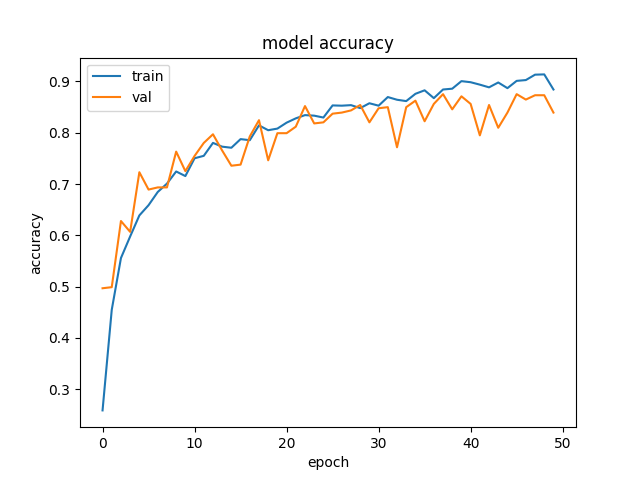

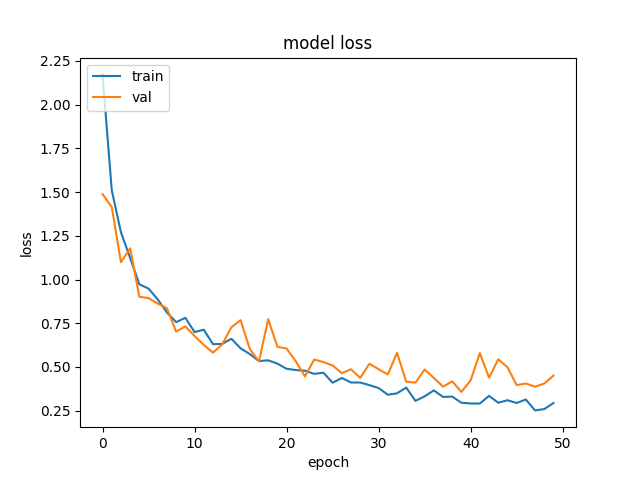

#### 5.1 Poids des espèces

Va permettre un meilleur traitement lors du training des datas

In [ ]:
def weigth(training_set):
    for k, v in training_set.class_indices.items():
        label_map[v] = k

    class_counts = pd.Series(training_set.classes).value_counts()

    for i, c in class_counts.items():
        class_weight[i] = 1.0 / c

    norm_factor = np.mean(list(class_weight.values()))

    for k in class_counts.keys():
        class_weight[k] = class_weight[k] / norm_factor

    t = PrettyTable(['class_index', 'class_label', 'class_weight'])
    for i in sorted(class_weight.keys()):
        t.add_row([i, label_map[i], '{:.2f}'.format(class_weight[i])])
    print(t)

### 6. Preprocessing
A partir de nos observation sur les graphiques présent dans makepreprocessing nous avons conclue une zone de délimation pour isoler le vert ((27, 50, 0), (50, 255, 255)) présent sur nos photos

In [ ]:
def color_segment_function(img_array):
    img_array = np.rint(img_array)
    img_array = img_array.astype('uint8')
    hsv_img = cv.cvtColor(img_array, cv.COLOR_RGB2HSV)
    mask = cv.inRange(hsv_img, (27, 50, 0), (50, 255, 255))
    result = cv.bitwise_and(img_array, img_array, mask=mask)
    result = result.astype('float64')
    return result

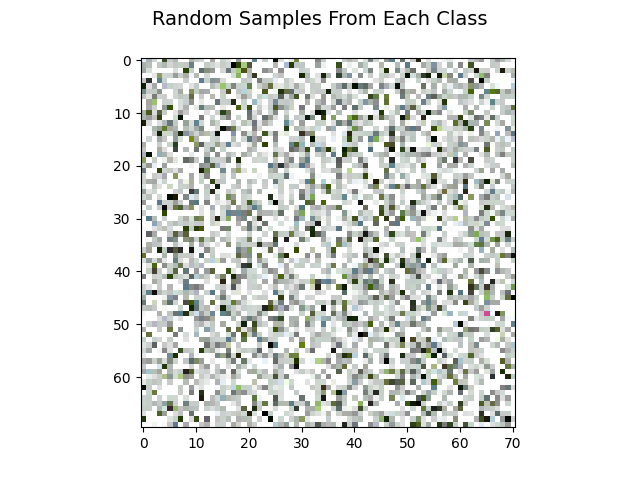

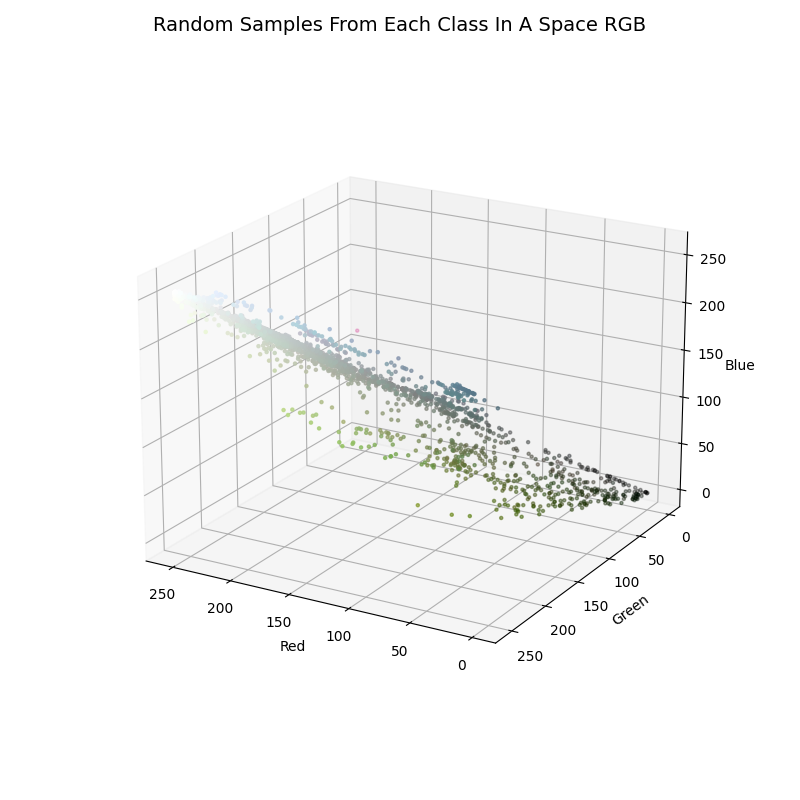

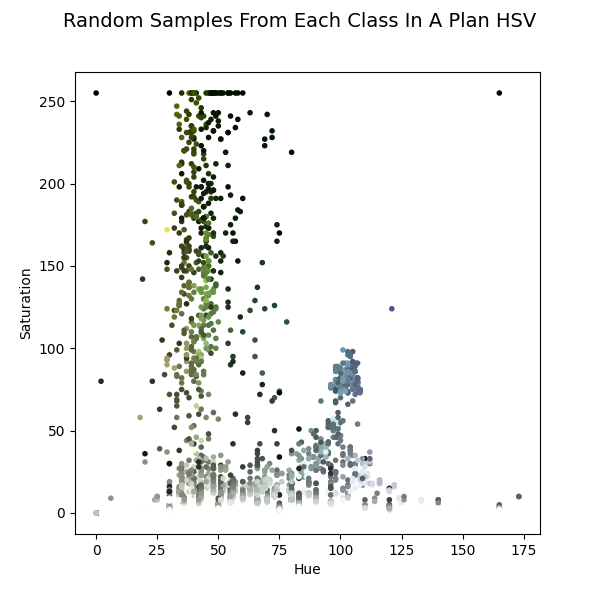

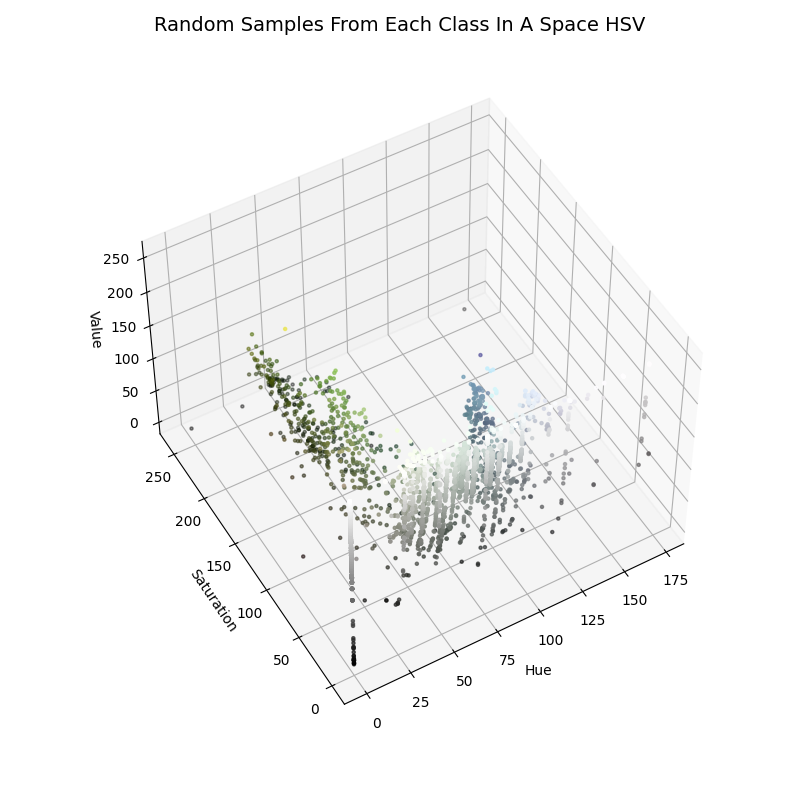

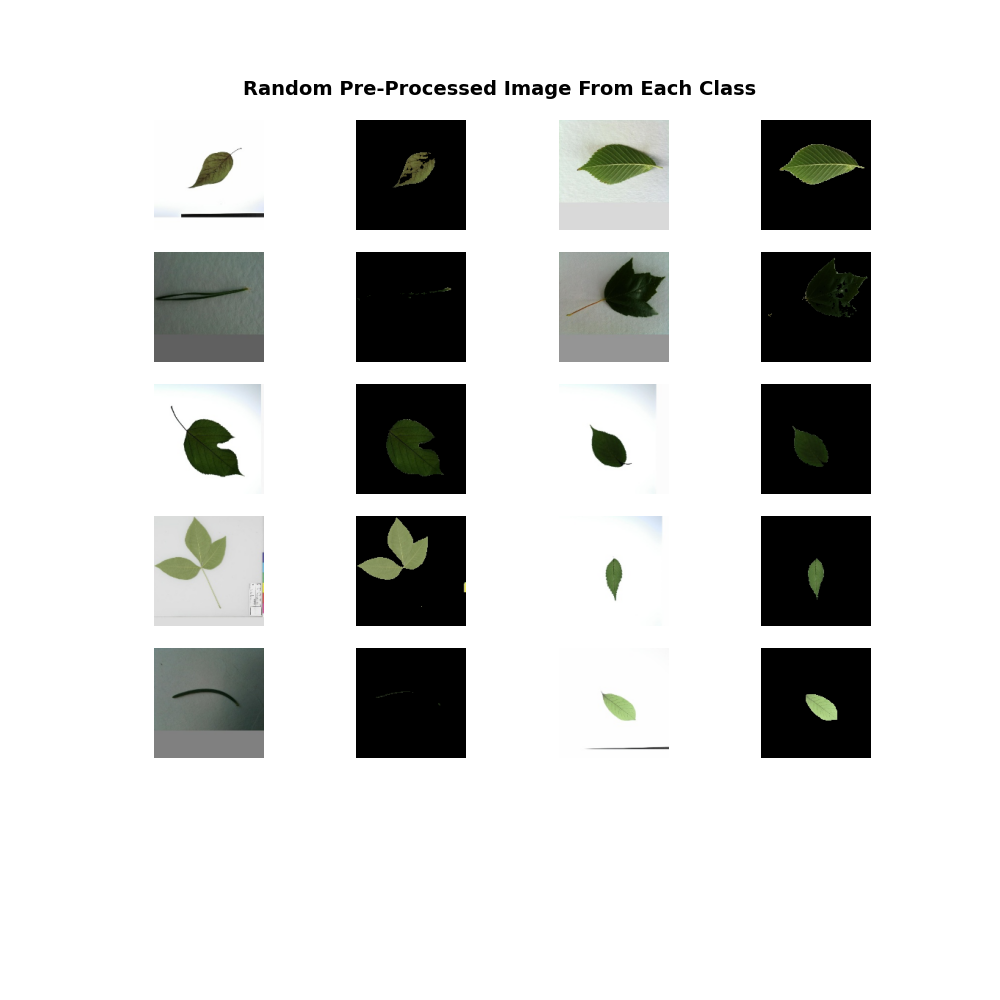

### 7. Prédiction
#### 7.1 Préparation des images de la prédiction
on rédefinie les photos se trouvant dans le dossier test et on les prépares pour etre traité par notre modèle

- rem: auncune photo se trouve dans le dossier train ou validatio  

In [ ]:
test_generator = test_datagen.flow_from_directory(
        char_path_test,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

#### 7.2 Effectue la prédiction et on l'affiche 
1. on effectue la prediction
2. on lie les resultats avec notre dictionnaire
3. affiche le résultat de la prédiction sous forme de tableau 


In [ ]:
print('---- Résultat de la prédiction -----')
result = model.predict(test_generator, steps=test_generator.n, verbose=1)
predicted_class_indices = np.argmax(result, axis=1)
prediction_labels = [label_map[k] for k in predicted_class_indices]
filenames = test_generator.filenames
headers = ['file', 'species']
t = PrettyTable(headers)
for i, f, p in zip(range(len(filenames)), filenames, prediction_labels):
    if i < 10:
        t.add_row([os.path.basename(f), p])
    elif i < 13:
        t.add_row(['.', '.'])
print(t)

In [ ]:
+-----------------------+--------------------------+
|          file         |         species          |
+-----------------------+--------------------------+
|    Acer_rubrum.jpg    |       acer_rubrum        |
|      Asimina.jpg      |     asimina_triloba      |
|   abies_concolor.jpg  |      abies_concolor      |
|   broussonettia.jpg   | broussonettia_papyrifera |
|  maclura_pomifera.jpg |     maclura_pomifera     |
|  prunus_sargentie.jpg |     prunus_sargentii     |
|  prunus_virginia.jpg  |       ulmus_rubra        |
| ptelea_trifoliata.jpg |    ptelea_trifoliata     |
|    ulmus_pumila.jpg   |     prunus_sargentii     |
|    ulmus_rubra.jpg    |       ulmus_rubra        |
+-----------------------+--------------------------+